# MNIST test file
Rotate and shift only one image of each category (number) and use it for training. Use all the other images in the dataset for testing.

Used for evaluating the functionality of the method for the fingerprints.

### Possible further development
<ul>
    <li>Compare results for different choices of training images.</li>
</ul>

### Previous results
sigma rot | sigma u/d | n rots | n_estimators| mean score of 5 |
:--- | :--- | :--- | :--- | ---: |
10 | dim/10 | 100 | 100 | 0.5562460410068345 |
20 | dim/10 | 100 | 100 | 0.556752792132022 |
30 | dim/10 | 100 | 100 | 0.5230938489748291 |
40 | dim/10 | 100 | 100 | 0.5146291048508085 |
50 | dim/10 | 100 | 100 | 0.47648274712452077 |

Dim represents the dimension (IMG_SIZE&corc;) in each direction.

In [22]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from sklearn.datasets import load_digits
from mnist import MNIST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
mndata = MNIST("MNIST")
images,labels = mndata.load_training()

In [3]:
df=pd.DataFrame()
df["Images"]=images
df["Target"]=labels

In [4]:
def my_train_test_split(df):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(df)):
        data = df.iloc[i]
        if data[1] in y_train:
            X_test.append(data[0])
            y_test.append(data[1])
        else:
            X_train.append(data[0])
            y_train.append(data[1])
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = my_train_test_split(df)

In [6]:
y_train

[5, 0, 4, 1, 9, 2, 3, 6, 7, 8]

In [104]:
# Constants
N_ROTATIONS = 10 # Number of rotations per image
SIGMA_ROT = 10
IMG_SIZE0 = 28
IMG_SIZE1 = 28

In [91]:
def crop_center(img):
    dim0, dim1 = img.shape
    x0 = (dim0-IMG_SIZE0)//2
    x1 = (dim1-IMG_SIZE1)//2
    if dim0 < IMG_SIZE0:
        cropped_img = np.ones((IMG_SIZE0,IMG_SIZE1))*0
        dim1_crop = img[:,x1:x1+IMG_SIZE1]
        cropped_img[:dim0,:] = dim1_crop # Put image to the left. Possible source of error
    else:
        cropped_img = img[x0:x0+IMG_SIZE0,x1:x1+IMG_SIZE1]
    return cropped_img

In [101]:
def rotate_image(img):
    # Constants
    shift0 = int(rnd.gauss(0,IMG_SIZE0/10)) # The choice of random function should perhaps be reconsidered
    shift1 = int(rnd.gauss(0,IMG_SIZE1/10))
    deg = rnd.gauss(0,SIGMA_ROT) # Uncomment for gaussian distribution
    # deg = rnd.uniform(0,360) # Uncomment for uniform distribution
    # Necessary modification
    img = np.reshape(img, (IMG_SIZE0,IMG_SIZE1)) # If the input array is flattened
    # Transform the image
    new_img = ndimage.rotate(img, deg, reshape=True, cval=0) # cval gives value to fill added edges with
    new_img = ndimage.shift(new_img, [shift0, shift1], cval=0)
    new_img = crop_center(new_img)
    # plt.imshow(new_img, cmap="gray") # Uncomment to see image
    new_img = new_img.flatten() # Comment out if array should not be flattened
    return new_img

In [105]:
# Extend training set
X_train_new = []
y_train_new = []
for i in range(len(X_train)):
    y_train_new.extend([y_train[i]]*N_ROTATIONS)
    for j in range(N_ROTATIONS):
        X_train_new.append(rotate_image(X_train[i]))

# Algorithm training

In [27]:
model = RandomForestClassifier(n_estimators=100) # Larger n_estimators takes longer to calculate

In [106]:
model.fit(X_train_new,y_train_new)
model.score(X_test,y_test)

0.3877979663277213

Text(33.0, 0.5, 'Truth')

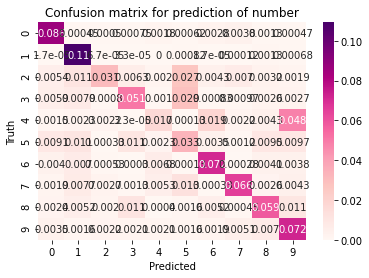

In [99]:
# Confusion matrix
# Predict class for X.
y_predicted = model.predict(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_predicted, normalize='all') # Remove 'normalize="all"' to get absolute numbers
plt.figure()
sn.heatmap(cm, annot=True, cmap='RdPu')
plt.title('Confusion matrix for prediction of number')
plt.xlabel('Predicted')
plt.ylabel('Truth')